In [41]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

from utils import Linear, Sequential
import random

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical, Normal

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
device

'cpu'

In [52]:
# Hyperparameters
max_timesteps = 3000
n_epochs = 10
learning_rate = 0.0003
gamma = 0.99
eps_clip = 0.2
K_epochs = 4
action_std = 0.5
batch_size = 64
update_timestep = 2000

beta = 0.0

In [53]:
def compute_gae(done, rewards, values, next_values, gamma=0.99, lambda_=0.95):
    assert len(values) == len(next_values) == len(rewards) == len(done)

    advantages = torch.zeros(done.shape[0], dtype=torch.float32)
    returns = torch.zeros(done.shape[0], dtype=torch.float32)
    last_advantage = 0
    last_return = 0

    for t in reversed(range(done.shape[0])):
        mask = 1.0 - done[t]
        last_value = next_values[t] * mask
        last_advantage = last_advantage * mask
        last_return = last_return * mask

        delta = rewards[t] + gamma * last_value - values[t]
        last_advantage = delta + gamma * lambda_ * last_advantage
        last_return = rewards[t] + gamma * last_return

        advantages[t] = last_advantage
        returns[t] = last_return

    return advantages, returns

In [54]:
class ActorCriticContinuous(nn.Module):
    def __init__(self, n_anchors, state_dim, action_dim, same_init, actor_hidden_layers, critic_hidden_layers, action_std):
        super(ActorCriticContinuous, self).__init__()
        
        # Define actor network
        actor_layers = []
        input_dim = state_dim
        for hidden_dim in actor_hidden_layers:
            actor_layers.append(Linear(n_anchors, input_dim, hidden_dim, same_init=same_init))
            actor_layers.append(nn.ReLU())
            input_dim = hidden_dim
        actor_layers.append(Linear(n_anchors, input_dim, action_dim, same_init=same_init))
        self.actor = Sequential(*actor_layers)
        self.n_anchors = n_anchors
        
        # Define critic network
        critic_layers = []
        input_dim = state_dim
        for hidden_dim in critic_hidden_layers:
            critic_layers.append(nn.Linear(input_dim, hidden_dim))
            critic_layers.append(nn.ReLU())
            input_dim = hidden_dim
        critic_layers.append(nn.Linear(input_dim, 1))
        self.critic = nn.Sequential(*critic_layers)
        
        self.action_var = nn.Parameter(torch.full((action_dim,), action_std**2, requires_grad=True))


    def forward(self, x, alpha, action=None):
        action_mean = self.actor(x, alpha)
        cov_matrix = torch.exp(self.action_var)
        dist = Normal(loc=action_mean, scale=cov_matrix)
        
        if action is None:
            action = dist.sample()
            
        log_p = dist.log_prob(action).sum(dim=-1)
        
        value = self.critic(x)
        
        return action, log_p, value, dist.entropy()
    
    
    def cosine_similarity(self,i,j):
        assert (i < self.n_anchors) and (j < self.n_anchors), "index higher than n_anchors"
        cos_sim = torch.Tensor([0.]).to(device)
        n = 0
        for module in self.actor:
            if isinstance(module,Linear):
                w1 = module.anchors[i].weight
                w2 = module.anchors[j].weight
                p1 = ((w1 * w2).sum() / max(((w1 ** 2).sum().sqrt() * (w2 ** 2).sum().sqrt()),1e-8)) ** 2
                b1 = module.anchors[i].bias
                b2 = module.anchors[j].bias
                p2 = ((b1 * b2).sum() / max(((b1 ** 2).sum().sqrt() * (b2 ** 2).sum().sqrt()),1e-8)) ** 2
                cos_sim += p1 + p2
                n += 2
        return cos_sim / n

In [55]:
def collect_trajectories(env, model, alpha, n_steps):

    states, actions, rewards, log_ps, state_values, dones = [], [], [], [], [], []

    state, _ = env.reset()
    

    total_reward = 0
    step_count = 0

    for _ in range(n_steps):
        state = torch.FloatTensor(state).to(device)
        action, log_p, state_value, entropy = model(state, alpha)
        next_state, reward, terminated, truncated, info = env.step(action.cpu().numpy())
        done = terminated or truncated

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        log_ps.append(log_p)
        state_values.append(state_value)
        dones.append(done)

        state = next_state
        total_reward += reward
        step_count += 1

        if done:
            state, _ = env.reset()
            
    next_value = model.critic(torch.FloatTensor(next_state).unsqueeze(0).to(device)).squeeze(0).cpu()
    
    states = torch.stack(states)
    
    actions = torch.LongTensor(actions) if action.shape == 1 else torch.stack(actions)
    rewards = torch.LongTensor(rewards)
    state_values = torch.FloatTensor(state_values)
    dones = torch.LongTensor(dones)
    next_state_values = torch.concatenate((state_values[1:], next_value))
    
    
    advantages, returns = compute_gae(dones, rewards, state_values, next_state_values)
         
    # Normalize advantages
    advantages = torch.FloatTensor(advantages)
    returns = advantages + torch.FloatTensor(state_values)
            
    trajectories = {
        "states" : states.detach(),
        "actions" : actions.detach(),
        "rewards" : rewards.detach(),
        "dones" : dones.detach(),
        "log_ps" : torch.stack(log_ps).detach(),
        "state_values": state_values.detach(),
        "next_state_values": next_state_values.detach(),
        "returns" : returns.detach(),
        "advantages" : advantages.detach(),
    }
    
    return trajectories


# trajectories = collect_trajectories(env, model, n_steps=128)

# for key in trajectories:
#     print(key, trajectories[key].shape)

def shufffle_trajectory(trajectories):
    length = trajectories['states'].shape[0]
    permutation = torch.randperm(length)

    shuffled_trajectories = {key: tensor[permutation] for key, tensor in trajectories.items()}
    return shuffled_trajectories

# shuffled_trajectories = shufffle_trajectory(trajectories)

In [56]:
def ppo_optimization(trajectories, model, alpha, optimizer, epochs, batch_size):
    
    model.train()
    
    traj_states = trajectories["states"]
    traj_actions = trajectories["actions"]
    traj_log_ps = trajectories["log_ps"]
    traj_returns = trajectories["returns"]  
    traj_advantages = trajectories["advantages"]


    len_trajectory = traj_states.shape[0]

    for epoch in range(1, epochs+1):
        for i in range(len_trajectory // batch_size):
            state = traj_states[batch_size*i:batch_size*(i+1)].to(device)
            action = traj_actions[batch_size*i:batch_size*(i+1)].to(device)
            log_p = traj_log_ps[batch_size*i:batch_size*(i+1)].to(device)
            return_ = traj_returns[batch_size*i:batch_size*(i+1)].to(device)
            advantage = traj_advantages[batch_size*i:batch_size*(i+1)].to(device)
            
            new_action, new_log_p, new_state_value, entropy = model(state, alpha, action)
            assert(new_action == action).all()
            
            
            advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)

            new_log_p, log_p, advantage = new_log_p.reshape(-1), log_p.reshape(-1), advantage.reshape(-1)
            
            ratio = torch.exp(new_log_p - log_p.detach())
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-0.2, 1+0.2) * advantage
            policy_loss = - torch.min(surr1, surr2).mean()
            
            # print(policy_loss)
            
            
            return_, new_state_value = return_.reshape(-1), new_state_value.reshape(-1)
            critic_loss = ((return_ - new_state_value)**2).mean()
            
            
            j,k = random.sample(range(model.n_anchors),2)
            penalty = model.cosine_similarity(j,k)

            loss = policy_loss - 2e-7*entropy.mean() + 0.5*critic_loss + beta*penalty

            optimizer.zero_grad()
            loss.backward()
            clip_factor = torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            
# ppo_optimization(trajectories, model, optimizer, epochs=1, batch_size=5)
# ppo_optimization(shuffled_trajectory, model, alpha, optimizer, epochs=5, batch_size=256)

In [57]:
def evaluate(env, model, alpha):
    model.eval()

    state, _ = env.reset()
        
    total_reward = 0
    step_count = 0

    trajectory = []
    info = {
        'ffoot_touch_ground': [],
        'bfoot_touch_ground': [],
    }
    

    while True:
        trajectory.append(state)
        state = torch.FloatTensor(state).to(device)
        with torch.no_grad():
            action, log_p, state_value, entropy = model(state, alpha)
        next_state, reward, terminated, truncated, _ = env.step(action.cpu().numpy())

        info['bfoot_touch_ground'].append(int(5 in env.data.contact.geom2))
        info['ffoot_touch_ground'].append(int(8 in env.data.contact.geom2))
        
        done = terminated or truncated

        state = next_state
        total_reward += reward
        step_count += 1
        
        
        if done:
            break
        
    return total_reward, trajectory, info


def get_reward_from_trajectory(trajectory):
    save_ = []
    acc_reward = 0
    for i in range(len(trajectory['rewards'])):
        if trajectory['dones'][i] == True:
            save_.append(acc_reward)
            acc_reward = 0
        
        acc_reward += trajectory['rewards'][i]
    return np.median(save_)

In [58]:
def random_alpha(n_anchors):
    random_probs = torch.rand(1, n_anchors)
    proba_vector = random_probs / random_probs.sum(dim=1, keepdim=True)
    return proba_vector[0]

In [59]:
env = gym.make('HalfCheetah-v4', render_mode = "rgb_array")

n_anchors = 2
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]


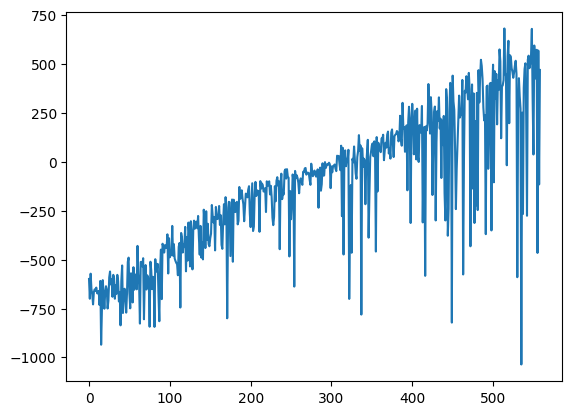

Reward: 469.0:  28%|██▊       | 559/2001 [09:45<21:39,  1.11it/s]

In [60]:
model = ActorCriticContinuous(
    n_anchors,
    state_dim,
    action_dim,
    same_init=False,
    actor_hidden_layers=[256, 256],
    critic_hidden_layers=[256, 256],
    action_std=0.5
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.0003)

rewards = []

tqdm_epochs = tqdm(range(0, 2000+1))
for epochs in tqdm_epochs:
    
    alpha = random_alpha(n_anchors).to(device)
    # alpha = torch.tensor([0.5, 0.5])
    print(alpha)
    
    trajectory = collect_trajectories(env, model, alpha, n_steps=1024)
    shuffled_trajectory = shufffle_trajectory(trajectory)
    ppo_optimization(shuffled_trajectory, model, alpha, optimizer, epochs=4, batch_size=256)
    

    # final_reward = np.mean([evaluate(env, model, random_alpha(n_anchors).to(device))[0] for _ in range(1)])
    final_reward = get_reward_from_trajectory(trajectory)
    rewards.append(final_reward)
    
    tqdm_epochs.set_description(f'Reward: {final_reward}')
    
    
    if epochs % 1 == 0:
        clear_output(True)
        plt.plot(rewards)
        plt.show()

In [14]:
# torch.save(model.state_dict(), 'models/halfcheetah/n_anchors=.pt')

---

In [15]:
model = ActorCriticContinuous(
    2,
    state_dim,
    action_dim,
    same_init=True,
    actor_hidden_layers=[256, 256],
    critic_hidden_layers=[256, 256],
    action_std=0.5
).to(device)

model.load_state_dict(torch.load('models/halfcheetah/n_anchors=2.pt'))

<All keys matched successfully>

In [16]:
def get_descriptor(info):
    return np.mean(info['bfoot_touch_ground']), np.mean(info['ffoot_touch_ground'])

In [18]:
descriptors = []
desc_rewards = []

for _ in tqdm(range(100)):
    reward, states, info = evaluate(env, model, random_alpha(n_anchors).to(device))
    descriptors.append(get_descriptor(info))
    rewards.append(reward)
    
descriptors_array = np.array(descriptors)

100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


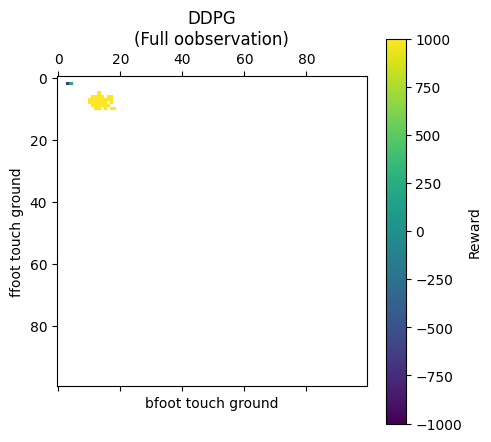

In [32]:
import matplotlib.pyplot as plt

x1, x2 = 0, 1

x1_min = 0
x1_max = 1
x2_min = 0
x2_max = 1

N = 100

x1_bins = np.linspace(x1_min, x1_max, N)
x2_bins = np.linspace(x2_min, x2_max, N)

map_grid = np.full((N, N), np.nan)


def get_bin(value, bins):
    return np.digitize(value, bins) - 1


for descriptor, reward in zip(descriptors, rewards):
    feature1, feature2 = descriptor[x1], descriptor[x2]
    f1_bin = get_bin(feature1, x1_bins)
    f2_bin = get_bin(feature2, x2_bins)
    
    if np.isnan(map_grid[f1_bin, f2_bin]):
        map_grid[f1_bin][f2_bin] = reward
    else:
        map_grid[f1_bin][f2_bin] = max(map_grid[f1_bin][f2_bin], reward) 
    
# for descriptor in anchor_descriptors:
#     feature1, feature2 = descriptor[x1], descriptor[x2]
#     f1_bin = get_bin(feature1, x1_bins)
#     f2_bin = get_bin(feature2, x2_bins)
#     map_grid[f1_bin][f2_bin] = -1


fig, axs = plt.subplots(1, 1, figsize=(5,5))


cax = axs.matshow(map_grid, cmap="viridis", vmin=-1000, vmax=1000)
axs.set_title('DDPG\n(Full oobservation)', loc='center')

axs.set_xlabel('bfoot touch ground')
axs.set_ylabel('ffoot touch ground')
# axs.set_xticklabels(x1_bins.round(2))
# axs.set_yticklabels(x2_bins.round(2))

fig.colorbar(cax, ax=axs, orientation='vertical', label='Reward')
plt.show()

True

In [59]:
from time import sleep

In [97]:
model = ActorCriticContinuous(
    n_anchors,
    state_dim,
    action_dim,
    same_init=True,
    actor_hidden_layers=[256, 256],
    critic_hidden_layers=[256, 256],
    action_std=0.5
).to(device)

# model.load_state_dict(torch.load('models/halfcheetah/n_anchors=1.pt'))


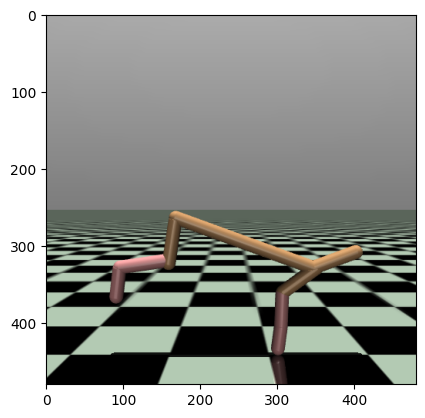

  0%|          | 14/3000 [00:15<55:02,  1.11s/it]

False True


KeyboardInterrupt: 

In [132]:
alpha = torch.tensor([1.])

state, _ = env.reset()
total_reward = 0
tqdm_range = tqdm(range(max_timesteps))
for t in tqdm_range:
    state = torch.FloatTensor(state).to(device)
    with torch.no_grad():
        action, log_p, state_value, entropy = model(state, alpha)
    next_state, reward, terminated, truncated, _ = env.step(action.cpu().numpy())
    done = terminated or truncated
    
    # Add data to memory
    # memory.add(state, action, reward, action_logprob, done)
    state = next_state
    total_reward += reward
    
    clear_output(True)
    frame = env.render()
    plt.imshow(frame)
    plt.show()
    
    # print(env.get_body_com('ffoot'))
    # print(env.data.body('bfoot').cfrc_int, env.data.body('ffoot').cfrc_int)
    
    
    # print(env.data.body('ffoot').xipos)
    # print(env.data.body('bfoot').cfrc_ext.any(), env.data.body('ffoot').cfrc_ext.any())
    # print(env.data.contact)
    print(5 in env.data.contact.geom2, 8 in env.data.contact.geom2)
    
    # if env.data.contact.H.shape[0] != 0:
        # break
    
    if done:
        break
    
    sleep(1)
    
print(total_reward)

In [129]:
env.data.contact.geom2

array([5, 8], dtype=int32)

In [102]:
env.data.body

<bound method PyCapsule.body of <mujoco._structs.MjData object at 0x754a173cd070>>

In [96]:
env.data.body('ffoot').cfrc_int

array([  0.        ,  22.1293691 ,   0.        , -52.90674133,
         0.        , -13.8416032 ])

In [94]:
env.data.body('bfoot').cfrc_int

array([  0.        , -65.58391056,   0.        , 124.25011867,
         0.        , -41.76418074])

In [95]:
env.data.body('bfoot')

<_MjDataBodyViews
  cacc: array([   0.        , -731.05017666,    0.        ,  -51.67292521,
          0.        ,  575.00922327])
  cfrc_ext: array([0., 0., 0., 0., 0., 0.])
  cfrc_int: array([  0.        , -65.58391056,   0.        , 124.25011867,
         0.        , -41.76418074])
  cinert: array([ 0.05770359,  0.76445357,  0.70785189,  0.        , -0.19661607,
        0.        , -0.87857201,  0.        , -0.24193659,  1.09539749])
  crb: array([ 0.05770359,  0.76445357,  0.70785189,  0.        , -0.19661607,
        0.        , -0.87857201,  0.        , -0.24193659,  1.09539749])
  cvel: array([ 0.        ,  7.11009233,  0.        ,  5.33851089,  0.        ,
       -5.19108022])
  id: 4
  name: 'bfoot'
  subtree_angmom: array([0., 0., 0.])
  subtree_com: array([2.04672575, 0.        , 0.42603072])
  subtree_linvel: array([0., 0., 0.])
  xfrc_applied: array([0., 0., 0., 0., 0., 0.])
  ximat: array([ 0.77652312,  0.        ,  0.63008876,  0.        ,  1.        ,
        0.        